# Auto-correlation based degree of freedom estimate

In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [2]:
import glob
import cartopy
import datetime
import scipy.io
import numpy as np
#import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from scipy import signal
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [3]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [4]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

base = datetime.datetime(2001, 1, 1)
date_list2 = [base + relativedelta(months=x) for x in range(168)]

In [155]:
def autocorrelation(series):
    n = len(series)
    data = np.asarray(series)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        acf_lag = ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return round(acf_lag, 3)
    x = np.arange(n) # Avoiding lag 0 calculation
    acf_coeffs = map(r, x)
    return np.asarray(acf_coeffs)

def crosscorrelation(x, y, k, normalize=True):
    n = x.shape[0]
    # initialize the output array
    out = np.empty((2 * k) + 1, dtype=np.double)
    lags = np.arange(-k, k + 1)
    # pre-compute E(x), E(y)
    mu_x = x.mean()
    mu_y = y.mean()
    # loop over lags
    for ii, lag in enumerate(lags):
        # use slice indexing to get 'shifted' views of the two input signals
        if lag < 0:
            xi = x[:lag]
            yi = y[-lag:]
        elif lag > 0:
            xi = x[:-lag]
            yi = y[lag:]
        else:
            xi = x
            yi = y
        # x - mu_x; y - mu_y
        xdiff = xi - mu_x
        ydiff = yi - mu_y
        # E[(x - mu_x) * (y - mu_y)]
        out[ii] = xdiff.dot(ydiff) / n
        # NB: xdiff.dot(ydiff) == (xdiff * ydiff).sum()
    if normalize:
        # E[(x - mu_x) * (y - mu_y)] / (sigma_x * sigma_y)
        out /=  np.std(x) * np.std(y)
    return lags, out

In [5]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
deptht = coordinate_obj.variables['nav_lev'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

In [21]:
MAT = scipy.io.loadmat('../../_data/MAT files/FWC_Mode1.mat'); PC1 = MAT['PC'][0, :]
MAT = scipy.io.loadmat('../../_data/MAT files/FWC_Mode2.mat'); PC2 = MAT['PC'][0, :]
MAT = scipy.io.loadmat('../../_data/MAT files/FWC_Mode3.mat'); PC3 = MAT['PC'][0, :]

In [9]:
MAT = scipy.io.loadmat('../../_data/Mask files/vdt_BG_mask.mat')
vdt_mask = MAT['mask_ANHA4'][:]
vdt_mask_fill = np.copy(vdt_mask)
vdt_mask_fill[vdt_mask_fill==2]=0.0
# ANHA4 EXH005 U/V
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current_d23.mat')
u = MAT['vozocrtx'][:]
v = MAT['vomecrty'][:]
speed = np.sqrt(u**2+v**2)
# vdt, BG indices
area = e1t[0, :, :]*e2t[0, :, :]
for i in range(144):
    speed[i, :, :]=speed[i, :, :]*area 
vdt = np.nanmean(speed[:, vdt_mask==2], 1)/np.nanmean(area[vdt_mask==2])
# SSH
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan; #ssh = Ats.seasonal_decomp3d(ssh)
bg = np.nanmax(ssh[:, vdt_mask==1], 1)

In [145]:
MAT = scipy.io.loadmat('../../_data/Exchange/NOAA-CPC_NAO.mat')
# NAO_NOAA= MAT['data'][((2002-1950)*12):((2015-1950)*12+12), 2]
NAO_NOAA2= MAT['data'][((2001-1950)*12):((2014-1950)*12+12), 2]
# MAT = scipy.io.loadmat('../../_data/Exchange/AO_inds.mat')
# AO_ANHA4 = MAT['AO_index'][0, :]
# # array NAO_NOAA iss from 2000-2013
#NAO_RM1 = np.zeros([144]); NAO_RM1[NAO_RM1==0]=np.nan
#for i in range(144): 
#     NAO_RM1[i] = np.mean(NAO_NOAA[i:i+24])
NAO_RM2 = np.zeros([144]); NAO_RM2[NAO_RM2==0]=np.nan
NAO_RM2[:] = np.convolve(NAO_NOAA2[6:-6], np.ones((12,))/12.0, mode='valid')[1:]

MAT = scipy.io.loadmat('../../_data/Exchange/AO_inds.mat')
NAO_ANHA4 = MAT['3rd_PC'][0, :]
NAO_ANHA4_2 = np.convolve(NAO_ANHA4, np.ones((12,))/12.0, mode='valid')[1:]

** Auto-correlation **

In [146]:
AR1 = autocorrelation(PC1)
AR2 = autocorrelation(PC2)
AR2_0 = autocorrelation(PC2[6:-6])
AR3 = autocorrelation(PC3)

AR_TDS = autocorrelation(vdt)
AR_NOAA = autocorrelation(NAO_RM2)
AR_CGRF = autocorrelation(NAO_ANHA4_2)
AR_BG = autocorrelation(bg)

** Cross-correlation **

In [179]:
# 36 is 144/4, 33 is (144-12)/4
_, CR1 = crosscorrelation(PC1, vdt, 36)
_, CR2 = crosscorrelation(PC2, NAO_RM2, 36)
_, CR3 = crosscorrelation(PC2[6:-6], NAO_ANHA4_2, 33)
_, CR4 = crosscorrelation(PC3, bg, 36)

In [176]:
def get_df(AR1, AR2, CR, n, L):
    return n/(2*np.sum(AR1[1:L-1]*AR2[1:L-1])+1+np.sum(CR[0:L]*CR[L+1:])+CR[L]**2) 

** Get degree of freedom **

$$
\mathrm{N^*} = \frac{\mathrm{N}}{\sum_{l=-L}^{L}\left[\rho_{xx}(l)\rho_{yy}(l)+\rho_{xy}(l)\rho_{yx}(l)\right]}
$$

* $\rho_{xx}(l)$ and $\rho_{yy}(l)$ are $l$-lagged auto-correlation.
* $\rho_{xy}(l)$ and $\rho_{yx}(l)$ are $l$-lagged cross-correlation. 
* $L$ is the maximum lag, can not be larger than $\mathrm{N/3}$, in this research, we choose $\mathrm{N/4}$. 

In [168]:
pearsonr(PC2, NAO_RM2)

(0.37774193856603727, 3.0486628435844897e-06)

In [169]:
pearsonr(PC2[6:-6], -1*NAO_ANHA4_2)

(0.49466426619911241, 1.6528428682835951e-09)

In [180]:
print("PC1 v.s. TDS, corr=0.805, N={}".format(get_df(AR1, AR_TDS, CR1, 144, 36)))
print("PC2 v.s. NAO NOAA-CPC, corr=0.378, N={}".format(get_df(AR2, AR_NOAA, CR2, 144, 36)))
print("PC2 v.s. NAO CGRF, corr=0.495, N={}".format(get_df(AR2_0, AR_CGRF, CR3, 120, 33)))
print("PC3 v.s. BG, corr=0.52, N={}".format(get_df(AR3, AR_BG, CR4, 144, 36)))

PC1 v.s. TDS, corr=0.805, N=7.40377315515
PC2 v.s. NAO NOAA-CPC, corr=0.378, N=24.6891937378
PC2 v.s. NAO CGRF, corr=0.495, N=15.9191202931
PC3 v.s. BG, corr=0.52, N=32.6378203995


** Correlation table **:

http://faculty.fortlewis.edu/chew_b/Documents/Table%20of%20critical%20values%20for%20Pearson%20correlation.htm

note: "N" in the tabel is the sample number, the degree of freedom in the table should be "N-2" (i.e. start from 2 instead of 4).

**Summary of new p valuew**

PC1 v.s. TDS (R=0.805, N=7) -----> p < 0.01

PC2 v.s. NAO NOAA-CPC (R=0.378, N=25) -----> p < 0.1

PC2 v.s. NAO CGRF (R=0.495, N=16) -----> p < 0.05

PC3 v.s. BG (R=0.52, N=33) -----> p < 0.01


** A quick look at the auto-correlation (start at 0-lag)**

In [163]:
def timeseries_setup(fig):
    ax = fig.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.itervalues()]
    ax.tick_params(axis="both", which="both", bottom="off", top="off",   
            labelbottom="on", left="off", right="off", labelleft="on")

    ax.grid(linestyle=':')
    ax.xaxis.grid(False)
    ax.set_xlim([0, 143])
    ax.set_ylim([-1, 1])
    #ax.set_ylabel('Auto-correlations (include 0-lag)', fontsize=14)
    return ax

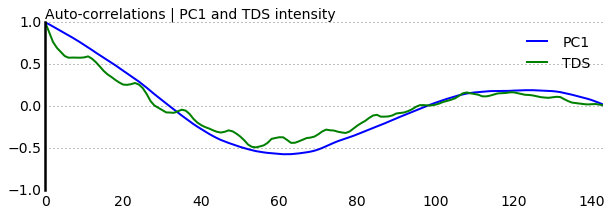

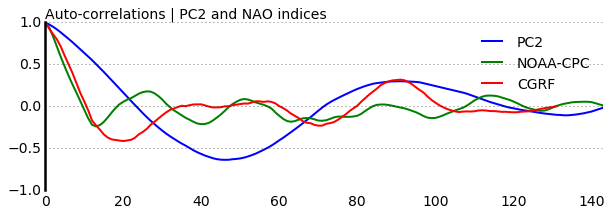

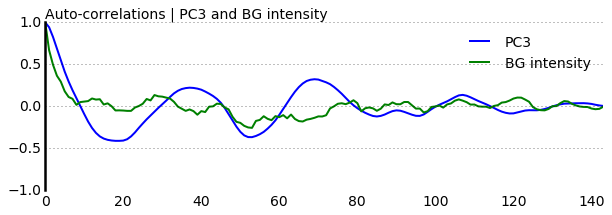

In [164]:
fig = plt.figure(figsize=(10, 3))
ax = timeseries_setup(fig)
ax.plot(AR1, lw=2, label='PC1')
ax.plot(AR_TDS, lw=2, label='TDS')
LG = ax.legend(bbox_to_anchor=(1, 1), prop={'size':14}); LG.draw_frame(False)
ax.set_title('Auto-correlations | PC1 and TDS intensity', loc='left', fontsize=14)

fig = plt.figure(figsize=(10, 3))
ax = timeseries_setup(fig)
ax.plot(AR2, lw=2, label='PC2')
ax.plot(AR_NOAA, lw=2, label='NOAA-CPC')
ax.plot(AR_CGRF, lw=2, label='CGRF')
LG = ax.legend(bbox_to_anchor=(1, 1), prop={'size':14}); LG.draw_frame(False)
ax.set_title('Auto-correlations | PC2 and NAO indices', loc='left', fontsize=14)

fig = plt.figure(figsize=(10, 3))
ax = timeseries_setup(fig)
ax.plot(AR3, lw=2, label='PC3')
ax.plot(AR_BG, lw=2, label='BG intensity')
LG = ax.legend(bbox_to_anchor=(1, 1), prop={'size':14}); LG.draw_frame(False)
ax.set_title('Auto-correlations | PC3 and BG intensity', loc='left', fontsize=14)